In [181]:
import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import sys
from numpy import linalg
from sklearn.mixture import GaussianMixture
import numpy as np
from scipy import stats
# from mayavi import mlab
import seaborn as sns
from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import uniform
import seaborn as sns
from sklearn.metrics import auc
from scipy.stats import gaussian_kde

In [168]:
from scipy.spatial.distance import euclidean
import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import sys
from numpy import linalg
from sklearn.mixture import GaussianMixture
import numpy as np
from scipy import stats
# from mayavi import mlab
import seaborn as sns
from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import uniform
import seaborn as sns
from scipy.stats import gaussian_kde
import matplotlib.patches as patches



In [4]:
from scipy.stats import gaussian_kde

In [9]:
def get_distribution_object(id = 1):
    d_dict = {}
    d_dict[1] = {
        'x': gamma(a = 2, loc= 1.0, scale=0.5),
        'y': gamma(a = 1, loc=-1.0, scale=0.75),
    }
    d_dict[2] = {
        'x': gamma(a = 1.0, loc = -1.5, scale=0.5),
        'y': gamma(a = 2.0, loc = 1.50, scale=0.5),
       
    }
    d_dict[3] = {
        'x': norm(loc = 1.25, scale =0.25),
        'y': norm(loc = 2.75, scale =0.25),
        
    }
    return d_dict[id]


def sample_from_dist(id = 1, size=500):
    obj = get_distribution_object(id)
    x = obj['x'].rvs(size=size)
    y = obj['y'].rvs(size=size)
    xy= np.vstack([x,y]).transpose()
    return xy


(30, 30)
(30, 30)
(30, 30)


/home/ddatta/anaconda3/envs/SG/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: The following kwargs were not used by contour: 'lw'
  del sys.path[0]
/home/ddatta/anaconda3/envs/SG/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: The following kwargs were not used by contour: 'lw'
  


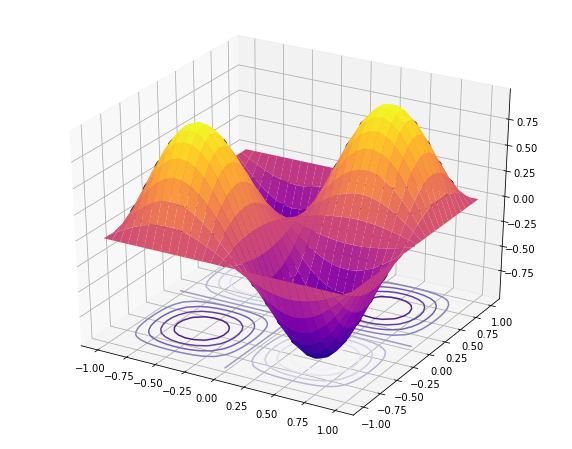

In [10]:
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111, projection="3d")
X, Y = np.mgrid[-1:1:30j, -1:1:30j]
print(X.shape)
print(Y.shape)
Z = np.sin(np.pi*X)*np.sin(np.pi*Y)
print(Z.shape)
ax.plot_surface(X, Y, Z, cmap="plasma", lw=0.5, rstride=1, cstride=1)
ax.contour(X, Y, Z, 10, lw=3, cmap="Purples", linestyles="solid", offset=-1)
ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
plt.show()

In [261]:
X1 = sample_from_dist(id = 1,size = 1000)
X2 = sample_from_dist(id = 2,size = 1000)
X3 = sample_from_dist(id = 3,size = 200) +  np.array([-2.5,-2])
X4 = sample_from_dist(id = 3,size = 200)

/home/ddatta/anaconda3/envs/SG/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  after removing the cwd from sys.path.
/home/ddatta/anaconda3/envs/SG/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  
/home/ddatta/anaconda3/envs/SG/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  if __name__ == '__main__':
/home/ddatta/anaconda3/envs/SG/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


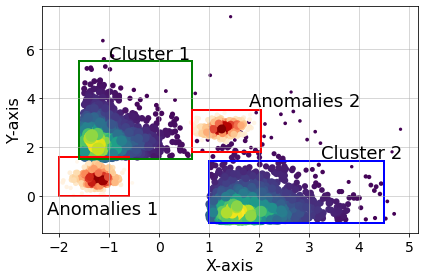

In [336]:
fig, ax = plt.subplots(figsize=[6,4])
z = gaussian_kde(X1.transpose())(X1.transpose())

ax.scatter(X1[:,0], X1[:,1], c=z, s = np.sqrt(z)*200, edgecolor='',cmap='viridis')
z = gaussian_kde(X2.transpose())(X2.transpose())
ax.scatter(X2[:,0], X2[:,1], c=z, s = np.sqrt(z)*200, edgecolor='',cmap='viridis')

z = gaussian_kde(X3.transpose())(X3.transpose())
ax.scatter(X3[:,0], X3[:,1], c=z, s=np.sqrt(z)*50, edgecolor='',cmap='OrRd')


rect_a = patches.Rectangle(
    (-2.0,0),
    1.4,1.6,
    linewidth=2,
    edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect_a)           
plt.annotate('Anomalies 1', (-2.250, -0.750), fontsize=18)

rect_c1 = patches.Rectangle(
    (-1.6,1.5),
    2.25,4,
    linewidth=2,
    edgecolor='g',
    facecolor='none')
ax.add_patch(rect_c1)           
plt.annotate('Cluster 1', (-1,5.6), fontsize=18)

rect_c2 = patches.Rectangle(
    (1,-1.1),
    3.5,2.5,
    linewidth=2,
    edgecolor='b',
    facecolor='none')
ax.add_patch(rect_c2)    
plt.annotate('Cluster 2', (3.25,1.55), fontsize=18)


z = gaussian_kde(X4.transpose())(X4.transpose())
ax.scatter(X4[:,0], X4[:,1], c=z, s=np.sqrt(z)*50, edgecolor='',cmap='OrRd')
rect_a = patches.Rectangle(
    (0.650,1.8),
    1.4,1.7,
    linewidth=2,
    edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect_a)           
plt.annotate('Anomalies 2', (1.80,3.650), fontsize=18)


plt.xlabel('X-axis',fontsize=16)
plt.ylabel('Y-axis',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(linewidth=0.5)
plt.tight_layout()
plt.savefig('concept_proof_v4.pdf')
plt.show()

In [193]:
def  plot_fig_v2(xyz_list , cmaps = None , text_annotations = None):
    
    import numpy as np
    from mpl_toolkits.mplot3d import axes3d
    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize=[16,12])
    ax = fig.gca(projection='3d')
    ax.set_facecolor('xkcd:white')
    ax.grid('major')
    ax.view_init(elev=20, azim=45)

    if cmaps is None:
        cmaps = ['ocean', 'inferno',"plasma" ]
    i = 0
    j = 0
    for _xyz in xyz_list:
        
        x = _xyz[:,0]
        y = _xyz[:,1]
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)
       
        ax.plot_trisurf(x, y,z, cmap=cmaps[i], linewidth=0.2)
        i = (i+1)% len(cmaps)
        
        ax.text(np.median(x) + 0.75, np.median(y),  np.max(z) + 0.2, text_annotations[j], fontsize=28)
        j += 1
                    
    plt.xlabel('X-Axis', fontsize=24)
    plt.ylabel('Y-Axis', fontsize=24)
    plt.tight_layout()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.savefig('viz_1.pdf')
    plt.show()
    return 

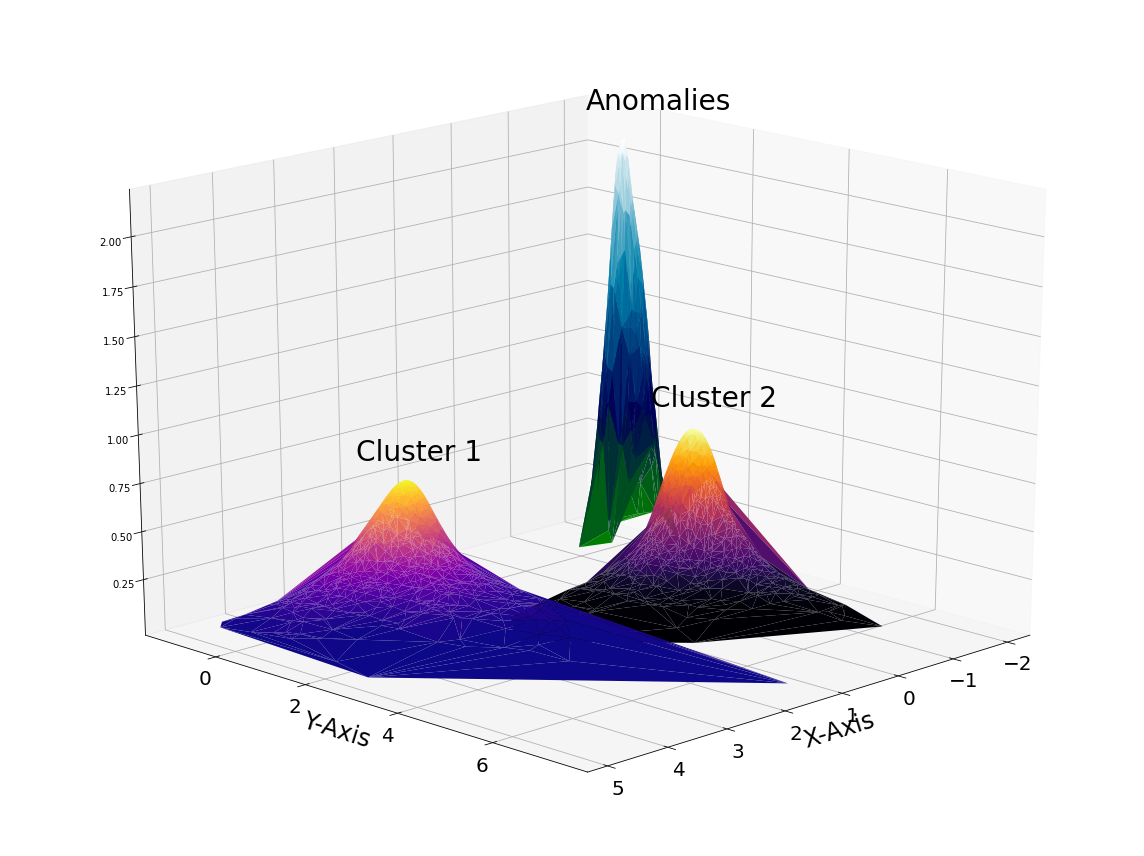

In [266]:
plot_fig_v2([X1,X2,X3], cmaps = ['plasma', 'inferno','ocean'], text_annotations = ['Cluster 1', 'Cluster 2', 'Anomalies'])


In [267]:
data = np.vstack([X1,X2])
anomaly_data =  np.vstack([X3,X4])
print('Data shapes', data.shape, anomaly_data.shape )

Data shapes (2000, 2) (400, 2)


In [268]:
def calculate_sample_energy(z , phi, mu, cov):
    e = 0
    num_comp = phi.shape[0]
    for k in range(num_comp):
        _mu = np.reshape(mu[0],[-1,1])
        p1 = z.reshape([-1,1]) - _mu 
        p2 = np.linalg.inv(cov[k])
        a = -0.5 * np.matmul( np.matmul ( p1.transpose(), p2), p1 )[0][0]
        b = np.exp(a)
        c = np.sqrt(2 * np.pi * np.linalg.det(cov[k]))
        e_k = phi[k] * b / c
        e += e_k
        
    e = - np.log(e)
    return e 

In [269]:
# ==========================
#  Split normal data
# ==========================
from sklearn.model_selection import train_test_split

train_X, test_X = train_test_split(data,test_size=0.25)

In [270]:
train_X.shape

(1500, 2)

In [271]:
# ================
# Train model 
# ================
gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(train_X)
cov = gmm.covariances_
mu = gmm.means_
phi = gmm.weights_

In [272]:
mu

array([[ 1.95857893, -0.22588138],
       [-1.00359925,  2.4761094 ]])

In [273]:
# ---------------------------------------------
# Calculate sample energy for each data point
# ---------------------------------------------
combined_labels = [ 0 for _ in range (test_X.shape[0]) ] + [ 1 for _ in range (anomaly_data.shape[0]) ] 

In [274]:
anomaly_data.shape[0]

400

In [275]:
normal_data_energy = []
for x in test_X:
    e = calculate_sample_energy(x , phi, mu, cov)
    
    normal_data_energy.append(e)

In [276]:
anom_data_energy = []
for x in anomaly_data:
    e = calculate_sample_energy(x , phi, mu, cov)
    anom_data_energy.append(e)

In [277]:
combined_scores = normal_data_energy + anom_data_energy

In [278]:
res_df = pd.DataFrame(data = np.vstack([combined_scores,combined_labels]).transpose(), columns=['score','label'])


def normalize_values(v,_max,_min):
    return (v - _min) / ( _max - _min)

_min = min(combined_scores)
_max = max(combined_scores)

res_df['score'] = res_df['score'].apply(normalize_values,args=(_max,_min))

_min = min(res_df['score'])
_max = max(res_df['score'])

In [279]:
res_df

,score,label
0,0.347500,0.0
1,0.554109,0.0
2,0.636779,0.0
3,0.003186,0.0
4,0.368330,0.0
...,...,...
895,0.232166,1.0
896,0.200954,1.0
897,0.224974,1.0
898,0.258371,1.0


In [280]:
step = 0.01
threshold = _max -step
total_anom_count = anomaly_data.shape[0]
R = [0]
P = []
while threshold > _min:
    sel = res_df.loc[res_df['score']>=threshold]

    correct = len(sel.loc[sel['label'] == 1])
    selected = len(sel)
    prec = correct/selected
    recall = correct/total_anom_count
  
    threshold -=step
    P.append(prec)
    R.append(recall)
P = [P[0]] + P

In [281]:
auc(R,P)

0.40153816271696385

# ----------------------------------------------------- #

In [282]:
def generate_neg_samples(dist_obj_list, min_x = -5, max_x = 7.5, min_y = -5, max_y = 7.5, n_samples = 15000):
    n_dist_obj = {
        'x': uniform(loc = min_x, scale = max_x - min_x),
        'y': uniform(loc = min_y, scale = max_y - min_y),
    }
    res = []
    count = 0
    while count < n_samples:
        _x = n_dist_obj['x'].rvs(size=1)[0]
        _y = n_dist_obj['y'].rvs(size=1)[0]
        accept = True
        for D in dist_obj_list:
            p = D['x'].pdf(_x) *  D['y'].pdf(_y) 
            if p > 0.05:
                accept = False
        if accept:
            res.append([_x,_y])
            count +=1
    return np.array(res)
    
    

In [283]:
dist_obj_list = [ get_distribution_object(id = 1), get_distribution_object(id = 2)]

In [284]:
neg_Samples = generate_neg_samples(dist_obj_list )

In [285]:
# plot_fig([X1, X2, neg_Samples])

In [286]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [287]:
# clf = MLPClassifier(
#     hidden_layer_sizes=(2,2,),
#     activation='tanh',
#     learning_rate='adaptive',
#     verbose = True
# )

clf = SVC(probability=True)       

In [288]:
clf_train_X = np.vstack([train_X, neg_Samples])

In [289]:
clf_train_Y = np.array( [1  for _ in range(train_X.shape[0]) ] + [0 for _ in range(neg_Samples.shape[0]) ] )

In [290]:
clf.fit(clf_train_X, clf_train_Y,  )

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [291]:
test_X_scores = list(clf.predict_proba(test_X)[:,0].reshape(-1))
anom_scores = list(clf.predict_proba(anomaly_data)[:,0].reshape(-1))

In [292]:
anom_scores

[0.8806020773804111,
 0.9896892207855285,
 0.980603496619242,
 0.987884618121823,
 0.7557412188729714,
 0.7171010113676309,
 0.9741947377384174,
 0.9526436864021913,
 0.9808746846622249,
 0.9430891468105334,
 0.9999129319142775,
 0.8233900566058397,
 0.8703501542912242,
 0.9996596941995026,
 0.9794556688788154,
 0.9380065255137955,
 0.9832952001489749,
 0.9492677857048408,
 0.8707847900332344,
 0.8191618698619255,
 0.9801007988964187,
 0.9956135702805881,
 0.9501241759658555,
 0.7374253644080808,
 0.9466249524538257,
 0.9898128097979622,
 0.9955655327345353,
 0.6391582849864811,
 0.9987520898384331,
 0.9003256512140412,
 0.7109286525767069,
 0.939739428027753,
 0.9922209573479429,
 0.7625576413421452,
 0.9721640672872869,
 0.9939990387728166,
 0.9209887866333469,
 0.9282722804154379,
 0.9862973119842532,
 0.7417403420856624,
 0.933532298507659,
 0.9806218609058027,
 0.9992974926880636,
 0.8635983691579645,
 0.9604035895603665,
 0.6855223539003611,
 0.9251424892655074,
 0.90993481559539

In [293]:
test_X_scores

[0.1907517929530002,
 0.26976387156637294,
 0.506961517751799,
 0.1487294765332034,
 0.4425881841872632,
 0.9999641804141052,
 0.16579286949693667,
 0.23422273978679004,
 0.8136576955151331,
 0.21902211246055586,
 0.15668840810347795,
 0.2519204773555899,
 0.46617257897128256,
 0.2078501222815104,
 0.21381291875846997,
 0.1735177850732235,
 0.15208852626379252,
 0.5390800151543629,
 0.2689862809324576,
 0.37204201270273485,
 0.22158452236603562,
 0.2060317515599562,
 0.46017845404684243,
 0.17406500439900188,
 0.3823591824596445,
 0.21928274816996,
 0.19587186301659992,
 0.19938827769467812,
 0.2711938898338978,
 0.22335126260797258,
 0.15519953332348865,
 0.1424533036532948,
 0.19634999538550207,
 0.20644605189021112,
 0.2506753493576691,
 0.27858395543987774,
 0.35492003916466347,
 0.16873232456368334,
 0.16371664648538456,
 0.1828998738160541,
 0.4212377579452586,
 0.18808337819998353,
 0.43056772864155424,
 0.14538859883341787,
 0.17587066739503945,
 0.3957348521729295,
 0.47837348

In [294]:
combined_scores =  test_X_scores + anom_scores

In [295]:
combined_labels = [ 0 for _ in range (test_X.shape[0]) ] + [ 1 for _ in range (anomaly_data.shape[0]) ] 
res_df = pd.DataFrame(
    data = np.vstack([combined_scores,combined_labels]).transpose(), 
    columns=['score','label']
)

def normalize_values(v,_max,_min):
    return (v - _min) / ( _max - _min)

_min = min(combined_scores)
_max = max(combined_scores)

res_df['score'] = res_df['score'].apply(normalize_values,args=(_max,_min))

_min = min(res_df['score'])
_max = max(res_df['score'])
print(_min,_max)

0.0 1.0


In [296]:
step = 0.01
threshold = _max - step
total_anom_count = anomaly_data.shape[0]
R = [0]
P = []

In [297]:
while threshold >_min:
    sel = res_df.loc[res_df['score']>=threshold]
    correct = len(sel.loc[sel['label'] == 1])
    selected = len(sel)
    prec = correct/selected
    recall = correct/total_anom_count
#     print(threshold, selected, prec, recall)
    threshold -=step
    P.append(prec)
    R.append(recall)

P = [P[0]] + P
print(auc(R,P))

0.9264307769162504


In [298]:
# ==============================
#  Lets try K means
# ==============================

In [299]:
from sklearn.cluster import KMeans


In [320]:
kmeans = KMeans(n_clusters=1, random_state=0).fit(train_X)

In [321]:
centers = kmeans.cluster_centers_
centers

array([[0.52678979, 1.0801444 ]])

In [322]:
def dist_from_centre(_X, centers, kmeans_obj):
    cluster_labels = kmeans.predict(_X)
    res_dist = []
    for i in range(_X.shape[0]):
        u = centers[cluster_labels[i]]
        v = _X[i]
        d = euclidean(u,v)
        res_dist.append(d)
    return np.array(res_dist)

In [323]:
combined_labels = [ 0 for _ in range (test_X.shape[0]) ] + [ 1 for _ in range (anomaly_data.shape[0]) ] 


In [324]:
test_data = np.vstack([test_X,anomaly_data])
test_data.shape

(900, 2)

In [325]:
combined_scores = dist_from_centre(test_data ,centers, kmeans)

In [326]:
res_df = pd.DataFrame(
    data = np.vstack([combined_scores,combined_labels]).transpose(), 
    columns=['score','label']
)

def normalize_values(v,_max,_min):
    return (v - _min) / ( _max - _min)

_min = min(combined_scores)
_max = max(combined_scores)

res_df['score'] = res_df['score'].apply(normalize_values,args=(_max,_min))

_min = min(res_df['score'])
_max = max(res_df['score'])
print(_min,_max)

0.0 1.0


In [327]:
step = 0.01
threshold = _max - step
total_anom_count = anomaly_data.shape[0]
R = [0]
P = []

In [328]:
while threshold > _min:
    sel = res_df.loc[res_df['score']>=threshold]
    correct = len(sel.loc[sel['label'] == 1])
    selected = len(sel)
    prec = correct/selected
    recall = correct/total_anom_count
  
    threshold -=step
    P.append(prec)
    R.append(recall)
P = [P[0]] + P

In [329]:
print(auc(R,P))

0.33380956975090353
